In [1]:
import numpy
from matplotlib import pyplot, animation
from IPython.display import HTML
%matplotlib inline

In [2]:
pyplot.rcParams['font.family'] = 'serif'
pyplot.rcParams['font.size'] = 16

In [4]:
from traffic import rho_red_light, flux

In [5]:
help(rho_red_light)

Help on function rho_red_light in module traffic:

rho_red_light(x, rho_max)
    Computes the "red light" initial condition with shock.
    
    Parameters
    ----------
    x : numpy.ndarray
        Locations on the road as a 1D array of floats.
    rho_max : float
        The maximum traffic density allowed.
    
    Returns
    -------
    rho : numpy.ndarray
        The initial car density along the road as a 1D array of floats.



In [6]:
nx = 100  
L = 4.0  
dx = L / nx 
nt = 30 
rho_max = 10.0  
u_max = 1.0  


x = numpy.linspace(0.0 + 0.5 * dx, L - 0.5 * dx, num=nx)

rho0 = rho_red_light(x, rho_max)

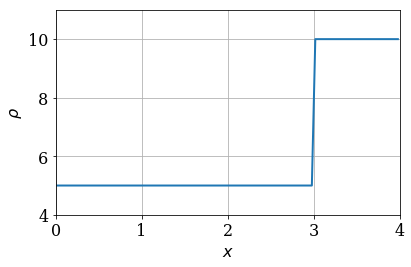

In [7]:
fig = pyplot.figure(figsize=(6.0, 4.0))
pyplot.xlabel(r'$x$')
pyplot.ylabel(r'$\rho$')
pyplot.grid()
line = pyplot.plot(x, rho0,
                   color='C0', linestyle='-', linewidth=2)[0]
pyplot.xlim(0.0, L)
pyplot.ylim(4.0, 11.0)
pyplot.tight_layout();

In [8]:
def godunov(rho0, nt, dt, dx, bc_values, *args):
    rho_hist = [rho0.copy()]
    rho = rho0.copy()
    for n in range(nt):
        rhoL = rho[:-1]  # i-th value at index i-1/2
        rhoR = rho[1:]  # i+1-th value at index i-1/2
        # Compute the flux at cell boundaries.
        F = 0.5 * (flux(rhoL, *args) + flux(rhoR, *args) -
                   dx / dt * (rhoR - rhoL))
        # Advance in time.
        rho[1:-1] = rho[1:-1] - dt / dx * (F[1:] - F[:-1])
        # Apply boundary conditions.
        rho[0], rho[-1] = bc_values
        # Record the time-step solution.
        rho_hist.append(rho.copy())
    return rho_hist

In [10]:
sigma = 1.0
dt = sigma * dx / u_max  
rho_hist = godunov(rho0, nt, dt, dx, (rho0[0], rho0[-1]),
                   u_max, rho_max)

In [11]:
def update_plot(n, rho_hist):
    fig.suptitle('Time step {:0>2}'.format(n))
    line.set_ydata(rho_hist[n])

In [12]:
def minmod(e, dx):
    sigma = numpy.zeros_like(e)
    for i in range(1, len(e) - 1):
        de_minus = (e[i] - e[i - 1]) / dx
        de_plus = (e[i + 1] - e[i]) / dx
        if de_minus > 0 and de_plus > 0:
            sigma[i] = min(de_minus, de_plus)
        elif de_minus < 0 and de_plus < 0:
            sigma[i] = max(de_minus, de_plus)
        else:
            sigma[i] = 0.0
    return sigma

In [13]:
def muscl(rho0, nt, dt, dx, bc_values, *args):
    def compute_flux(rho):
        sigma = minmod(rho, dx)
        rhoL = (rho + sigma * dx / 2.0)[:-1]
        rhoR = (rho - sigma * dx / 2.0)[1:]
        F = 0.5 * (flux(rhoL, *args) + flux(rhoR, *args) -
                   dx / dt * (rhoR - rhoL))
        return F
    rho_hist = [rho0.copy()]
    rho = rho0.copy()
    rho_star = rho.copy()
    for n in range(nt):
        F = compute_flux(rho)
        rho_star[1:-1] = rho[1:-1] - dt / dx * (F[1:] - F[:-1])
        rho_star[0], rho_star[-1] = bc_values
        F = compute_flux(rho_star)
        rho[1:-1] = 0.5 * (rho[1:-1] + rho_star[1:-1] -
                           dt / dx * (F[1:] - F[:-1]))
        rho[0], rho[-1] = bc_values
        rho_hist.append(rho.copy())
    return rho_hist

In [14]:
sigma = 1.0
dt = sigma * dx / u_max  
rho_hist = muscl(rho0, nt, dt, dx, (rho0[0], rho0[-1]),
                 u_max, rho_max)